# Implementation of time blocking for serialization and de-serialization of wavefields with Devito operators

## Introduction 

The goal of this tutorial is to prototype the serialization and de-serialization for wavefields in Devito. The motivation is using seismic modeling operators for full waveform inversion (FWI). Some of the steps in FWI require the re-use of previsouly computed wavefields, in particular the adjoint of the Jacobian linearized operator that maps data perturbation into velocity perturbation requires the wavefield computed with the nonlinear source. 

There are implemented alternatives to serialization / de-serialization like checkpointing (link to nb?), but we are investigating the serialization option here. In order to illustrate the use case for serialization, we write the workflow for computing the gradient of the FWI objective function, ignoring a lot of details, as follows:

1. Generate the nonlinear forward modeled data at the receivers $d_{mod}$
$$ 
d_{mod} = F m 
$$

1. Serialize the nonlinear source wavefield to disk during computation of 1. 

1. Compute the data residual $\delta r$ by differencing observed and modeled data at the receivers 
$$
\delta r = d_{obs} - d_{mod}
$$

1. Backproject the data residual $\delta r$ via time reversal. 

1. De-serialize the nonlinear source wavefield from disk during computation of 4, synchronizing time step between the nonlinear wavefield computed forward in time and time reversed adjoint wavefield. 

1. Increment the model perturbation with a correlation of the de-serialized nonlinear source wavefield and the backprojected receiver adjoint wavefield. Note that this computed model perturbation is the  _gradient_ of the FWI objective function.
$$
\delta m = \bigl( \nabla F\bigr)^\top\ \delta r
$$

The main motivation for this notebook is to show a proof of concept for serialization and de-serialization of the nonlinear wavefield. We will achieve this via _time blocking_: we will run a number of time steps in the generated c kernel, and then return control to python for the serialization and de-serialization operations.

Please see other notebooks in the project for more details, in particular the notebooks describing the self-adjoint modeling operators. More information: 
* Nonlinear operator ([sa_01_iso_implementation1.ipynb](sa_01_iso_implementation1.ipynb))
* Linearized operators ([sa_02_iso_implementation2.ipynb](sa_02_iso_implementation2.ipynb)).

## Outline 
1. Define symbols
1. Description of tests to verify correctness
1. Instantiate the model for a two dimensional problem
1. Nonlinear forward
  - Save all time steps implementation
  - Time blocking implementation
1. Jacobian linearized forward
  - Save all time steps implementation
  - Time blocking implementation
1. Jacobian linearized adjoint
  - Save all time steps implementation
  - Time blocking implementation
1. Discussion

## Table of symbols

We show the symbols here relevant to the implementation of the linearized operators.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m]\ q$ | Forward linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $q \rightarrow s$ |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |

## Description of tests to verify correctness

In order to make sure we have implemented these operators correctly, we will compare output from two runs:
 - a run with all time steps saved 
 - a run using the time blocking implementation
 
We will design the experiment with a source in the middle of the model and short enough elapsed modeling time that we do not need to worry about boundary reflections for these tests. 

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
from scipy.special import hankel2
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis, Model, AcquisitionGeometry
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm, Buffer)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import (acoustic_sa_setup, setup_w_over_q,
                                           SaIsoAcousticWaveSolver)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## Instantiate the model for a two dimensional problem
 - We use a small 500x500 m. model
 - We use 10x10 m. discretization 
 - We choose modeling sample rate explicitly (2 msec)
 - We use a modeling time range of 1 second
 - We use a wholespace model
   - velocity: 1500 m/s
   - density: 1 g/cm^3
 - We place the source in the center of the model
 - We use a vertical line of receivers right of center in model
 - We use the visco-acoustic absorbing boundary logic from the self-adjoint operators linked above, and add a 50 point absorbing boundary
 - We also generate a velocity perturbation that will be used in the linearized forward Jacobian operator

In [2]:
# NBVAL_IGNORE_OUTPUT

# Define dimensions for the interior of the model
nx,nz = 501,501
npad = 50
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define the dimensions 
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))

# Initialize the Devito grid 
dtype = np.float64
grid = Grid(extent=extent, shape=shape, origin=origin, dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

# Create velocity and buoyancy fields. 
space_order = 8
v = Function(name='v', grid=grid, space_order=space_order)
b = Function(name='b', grid=grid, space_order=space_order)
v.data[:] = 1.5
b.data[:,:] = 1.0 / 1.0

# Perturbation to velocity: a square offset from the center of the model
dm = Function(name='dm', grid=grid, space_order=space_order)
size = 10
x0 = (nx-1)//2
z0 = (nz-1)//2
dm.data[:] = 0.0
dm.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Initialize the attenuation profile for the absorbing boundary
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
wOverQ = Function(name='wOverQ_025', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

# Time sampling
t0 = dtype(0)     # Simulation time start
tn = dtype(200)  # Simulation time end (1 second = 1000 msec)
dt = dtype(2)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num
print("")
print("time_range; ", time_range)

# Source in the center of the model at 10 Hz center frequency
# Note we make two copes, one for save all and one for  time blocking
src1 = RickerSource(name='src1', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src2 = RickerSource(name='src2', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src1.coordinates.data[0,0] = src2.coordinates.data[0,0] = dx * 1/3 * (nx-1)
src1.coordinates.data[0,1] = src2.coordinates.data[0,1] = dz * (nz-1) / 2

# line of receivers along the right edge of the model
# Note we make two copes, one for save all and one for  time blocking
rec1 = Receiver(name='rec1', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * 2/3 * (nx-1)
rec1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

rec2 = Receiver(name='rec2', grid=grid, npoint=nz, time_range=time_range)
rec2.coordinates.data[:,0] = dx * 2/3 * (nx-1)
rec2.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("")
print("src_coordinate  X;         %+12.4f" % (src1.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src2.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec1.coordinates.data[:,0]), np.max(rec1.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec1.coordinates.data[:,1]), np.max(rec1.coordinates.data[:,1])))

shape;            (501, 501)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (5000.0, 5000.0)

grid.shape;       (501, 501)
grid.extent;      (5000.0, 5000.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


Operator `WOverQ_Operator` run in 0.01 s



time_range;  TimeAxis: start=0, stop=200, step=2, num=101

src_coordinate  X;           +1666.6667
src_coordinate  Z;           +2500.0000
rec_coordinates X min/max;   +3333.3333   +3333.3333
rec_coordinates Z min/max;      +0.0000   +5000.0000


## Plot velocity and density models

Next we plot the velocity and density models for illustration. 
- The source is shown as a large red asterisk

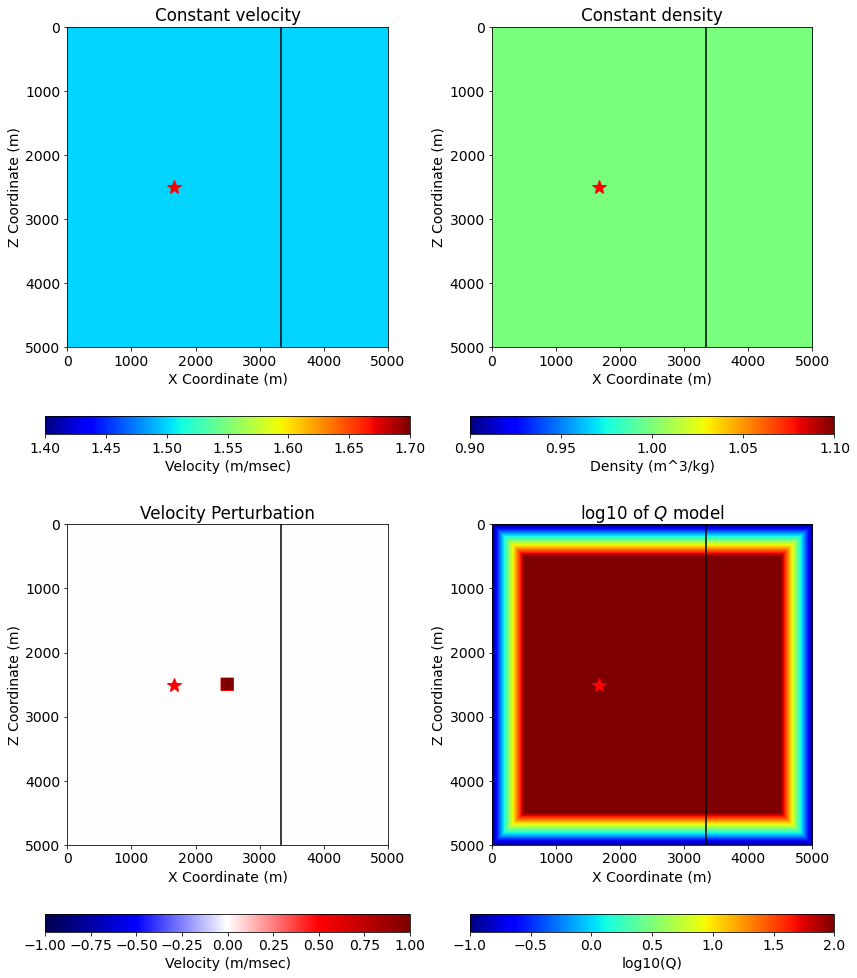

In [3]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin[0], origin[0] + extent[0], origin[1] + extent[1], origin[1]]

vmin, vmax = 1.4, 1.7
pmin, pmax = -1, +1
dmin, dmax = 0.9, 1.1

plt.figure(figsize=(12,14))

# plot velocity 
plt.subplot(2, 2, 1)
plt.imshow(np.transpose(v.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant velocity")

# plot density
plt.subplot(2, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Density (m^3/kg)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant density")

# plot velocity perturbation
plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

# Plot the log of the generated Q profile
q = np.log10(w / wOverQ.data)
lmin, lmax = np.log10(qmin), np.log10(100)

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(q.data), cmap=cm.jet, vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q$ model")

plt.tight_layout()
None

## Time blocking implementation of nonlinear forward

### Save all time steps implementation

We borrow the stencil from the self-adjoint operators shown in the jupyter notebooks linked above. 

When we instantiate the ```TimeFunction``` $u$ we pass the argument ```save=nt``` which allocates memory for ```nt``` time steps.

In [4]:
# NBVAL_IGNORE_OUTPUT

u1 = TimeFunction(name="u1", grid=grid, time_order=2, space_order=space_order, save=nt)
t,x,z = u1.dimensions

# Source terms (see notebooks linked above for more detail)
src1_term = src1.inject(field=u1.forward, expr=src1 * t.spacing**2 * v**2 / b)
rec1_term = rec1.interpolate(expr=u1.forward)

# Time update equation (see notebooks linked above for more detail)
eq_time_update = (t.spacing**2 * v**2 / b) * \
    ((b * u1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u1 + \
    (t.spacing * wOverQ - 1) * u1.backward

stencil = Eq(u1.forward, eq_time_update)

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Build and run the Operator
# Note the first time sample we run is 1, and the last is nt-2 
op1 = Operator([stencil] + src1_term + rec1_term, subs=spacing_map)
op1(time_m=1, time_M=nt - 2)
# print(op1)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.0}


Operator `Kernel` run in 0.25 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.23907799999999993, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4.799999999999996e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0009030000000000006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [5]:
# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
print(norm(u1))
assert np.isclose(norm(u1), 1129.293, atol=0, rtol=1e-3)

1129.293339341838


### Time blocking implementation

We now will instantiate a ```TimeFunction``` $u2$ that uses a ```Buffer``` for saving time steps. We choose the buffer size $M$, hopefully a reasonable number in practice that would allow time-tiling but still not create too large a memory footprint for $u2$.

In [6]:
M = 5
u2 = TimeFunction(name="u2", grid=grid, time_order=2, space_order=space_order, save=Buffer(M))

# Source and receiver terms (see notebooks linked above for more detail)
src2_term = src2.inject(field=u2.forward, expr=src2 * t.spacing**2 * v**2 / b)
rec2_term = rec2.interpolate(expr=u2.forward)

# We need to regenerate the time update equation with the new TimeFunction in order
# to get the time handling correct
eq_time_update = (t.spacing**2 * v**2 / b) * \
    ((b * u2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u2 + \
    (t.spacing * wOverQ - 1) * u2.backward

stencil = Eq(u2.forward, eq_time_update)

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Build the Operator 
configuration['jit-backdoor'] = 0
op2 = Operator([stencil] + src2_term + rec2_term, subs=spacing_map)
# print(op2)
# op2.arguments()

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.0}


### Run loop over blocks of M time steps

Here we will run $N$ blocks of $M$ time steps, where:
* the total number of time steps $nt$ 
* the number of time steps in a time block $M$ 
* the number of time blocks $N = \frac{\displaystyle nt}{\displaystyle M}$.

In [7]:
# NBVAL_IGNORE_OUTPUT

# We make an array the full size in order to save the time blocked wavefield
# for comparison with u1 above
u2_all = np.zeros(u1.data.shape, dtype=dtype)

# Number of time blocks
N = int((nt - 1) / M)

# Open a binary file in append mode to save the wavefield chunks  
filename = "timeblocking.nonlinear.bin"
f = open(filename, "ab")

u2.data[:] = 0
u2_all[:] = 0

for kN in range(0,N,1):
    kt1_save = (kN + 0) * M
    kt2_save = (kN + 1) * M - 1
    # minimum time sample is 1, maximum time sample is nt-2
    kt1 = max(kt1_save, 1)
    kt2 = min(kt2_save, nt - 2)
    op2(time_m=kt1, time_M=kt2)
    np.save(f, u2.data)
    # save the computed wavefield, not we will overwrite the sample (kt2+1) for each time block
    for kt in range(1, M + 1):
        ft = kt1_save + kt
        u2_all[ft,:,:] = u2.data[kt,:,:]

dmax = np.max(np.abs(u1.data - u2_all))
print("Maximum difference %+12.8e" % (dmax))

assert np.isclose(dmax, 0, atol=0, rtol=1e-12)

del u2, u2_all

Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s
Operator `Kernel` run in 0.02 s


Maximum difference +0.00000000e+00


## Time blocking implementation of Jacobian linearized forward

### Save all time steps implementation

We borrow the stencil from the self-adjoint operators shown in the jupyter notebooks linked above, with the argument ```save=nt``` as used above for the nonlinear forward.

## Time blocking implementation of Jacobian linearized adjoint

blah

### Save all time steps implementation

We borrow the stencil from the self-adjoint operators shown in the jupyter notebooks linked above, with the argument ```save=nt``` as used above for the nonlinear forward.